In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
np.random.seed(42)


# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
from simpleLayer import simpleLayer
testLay = simpleLayer(0,50,200)

In [3]:
from simpleDisk import simpleDisk
testDisk = simpleDisk(0,300,60,300)

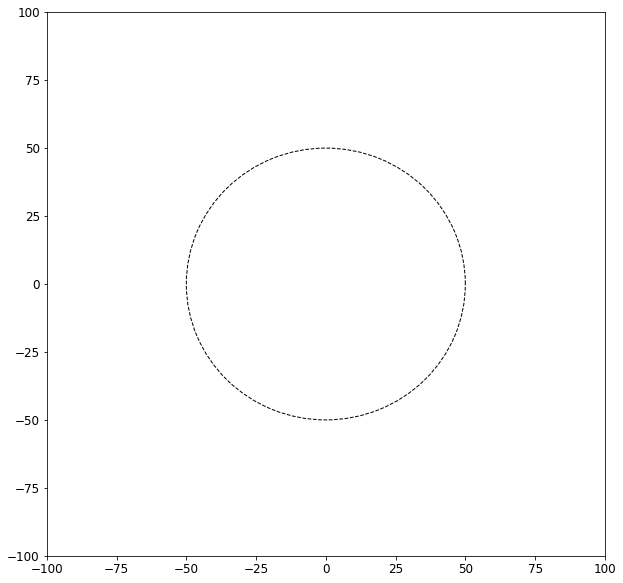

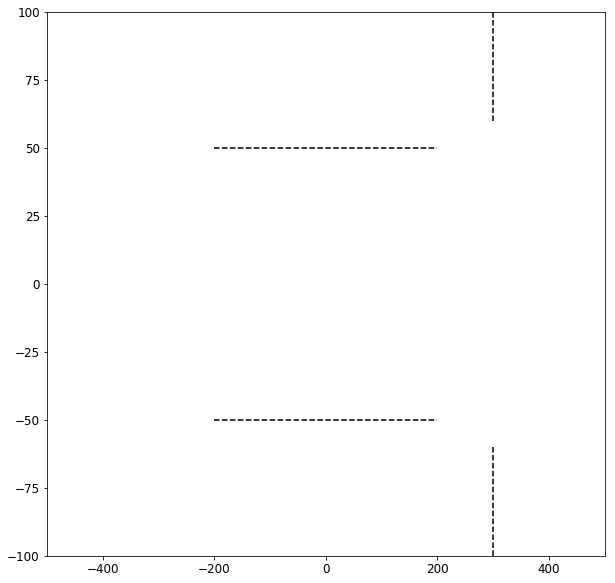

In [4]:
fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 100
ax.set_xlim((-1*zoom, zoom))
ax.set_ylim((-1*zoom, zoom))

testLay.drawDetectorXY(ax)


fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 100
ax.set_xlim((-500, 500))
ax.set_ylim((-1*zoom, zoom))
testLay.drawDetectorZR(ax)
testDisk.drawDetectorZR(ax)

# Lets build the detector

In [5]:
# Barrel
rDet = np.array([ 50, 100, 150, 200, 250, 300])
zDet = np.array([400, 400, 400, 400, 400, 400])

# End Cap
zDet_disk = np.array([ 450, 500, 600, 750, 900, 1100])
rStart_disk = np.array([ 60, 60, 60, 60, 60, 60])
rEnd_disk = np.array([ 300, 300, 300, 300, 300, 300])


from simpleDetectorGeo import simpleDetectorGeo
detGeo = simpleDetectorGeo(rDet,zDet,zDet_disk,rStart_disk,rEnd_disk)


/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:39: RuntimeWarning: invalid value encountered in sqrt
  yp = yc+np.sqrt(r**2-(x-xc)**2)
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:41: RuntimeWarning: invalid value encountered in sqrt
  ym = yc-np.sqrt(r**2-(x-xc)**2)


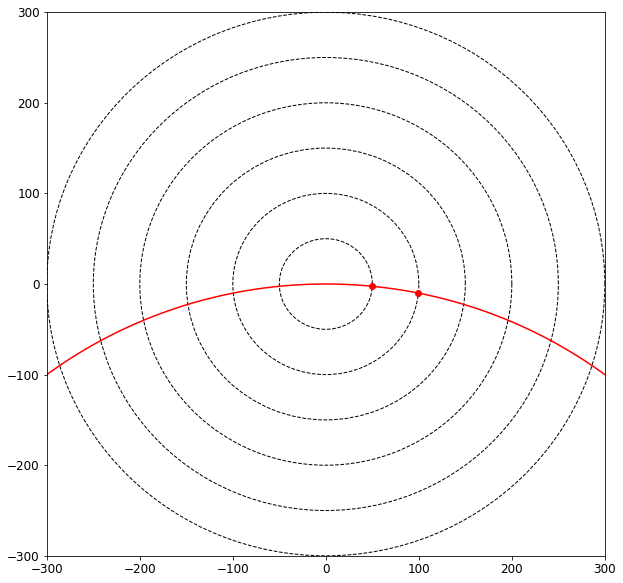

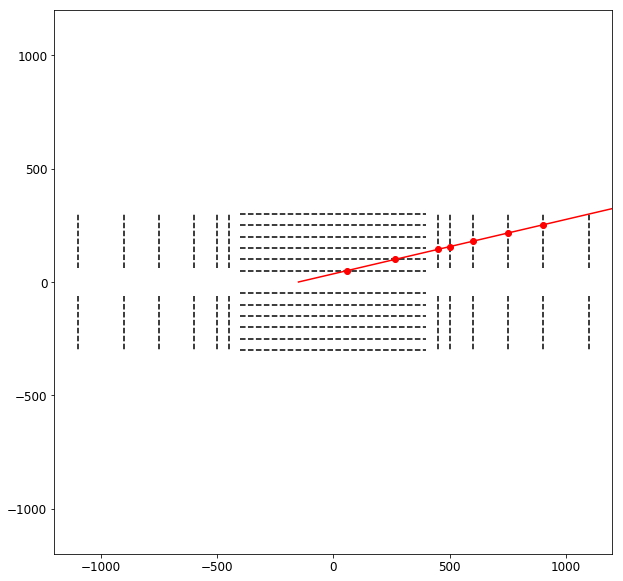

In [6]:
from TrackHelper import drawTrackXY
from TrackHelper import drawTrackZR

fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 300
ax.set_xlim((-1*zoom, zoom))
ax.set_ylim((-1*zoom, zoom))

detGeo.drawDetectorXY(ax)

phi=0
pt=500
z0 = -150
theta = 30*np.pi/400  # 30/400
xs, ys, zs, rs, layerIDs, becs = detGeo.getHits3D(pt,phi,theta, z0,+1)



drawTrackXY(pt,phi,+1,scale=1000)
plt.plot(xs[becs==0],ys[becs==0],'ro')

fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 1200
ax.set_xlim((-zoom, zoom))
ax.set_ylim((-1*zoom, zoom))

detGeo.drawDetectorZR(ax)
drawTrackZR(theta,z0,+1,zoom)
plt.plot(zs,rs,'ro')

## Get Truth Tracks


In [7]:
np.random.seed(42)

# Kaggle formats
eventParticles = []
eventTruth = []
eventHits = []

# For plotting 
solutions = []


nTrk = 50*3
hitID = 0

for trkI in range(nTrk):
    ptInv = np.random.uniform(0.01*0.001,3*0.001,1)[0]
    z0    = np.random.uniform(-150,150,1)[0]
    theta = np.random.uniform(370*np.pi/400,30*np.pi/400,1)[0]
    phi   = np.random.uniform(0.0,2*np.pi,1)[0]
    q     = 2*np.random.randint(0,2,1)[0]-1
    pt = 1./ptInv

    eventParticles.append((trkI,pt,phi,theta,z0,q,6))

    xHits, yHits, zHits, rHits, layers, becs = detGeo.getHits3D(pt,phi,theta, z0,q)

    solutions.append([xHits,yHits,zHits, rHits, pt,phi,theta, z0,q])
    for hitItr in range(len(xHits)):
        # hit_id, particle_id, tx, ty, tz, weight (=1 for now)
        eventTruth.append((hitID,trkI,xHits[hitItr],yHits[hitItr],zHits[hitItr],1.0))

        layID = abs(layers[hitItr])
        becID = becs[hitItr]        
        layerID = layers[hitItr]

        if becID == 1:
            layerID = layID+len(rDet)-1
        if becID == -1:
            layerID = layID+(2*len(rDet))-1
        if layerID==18: print(layID,becID,layerID)

        eventHits .append((hitID,xHits[hitItr],yHits[hitItr],zHits[hitItr],layerID))        
        hitID += 1

/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:134: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mp = abs(yints_raw-trk_yc+np.sqrt(trk_rc2-(xints_m_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:135: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mm = abs(yints_raw-trk_yc-np.sqrt(trk_rc2-(xints_m_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:124: RuntimeWarning: invalid value encountered in sqrt
  xints_p_raw =  1*np.sqrt(cylR**2-yints_raw**2)
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:125: RuntimeWarning: invalid value encountered in sqrt
  xints_m_raw = -1*np.sqrt(cylR**2-yints_raw**2)
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:132: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_pp = abs(yints_raw-trk_yc+np.sqrt(trk_rc2-(xints_p_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:133: RuntimeWarning: invalid value enco

## Make reconstructed hits from truth Hits  (add smearing and noise later)

In [8]:
recHits = np.array(eventHits)

np.random.seed(42)
shuffle_index = np.random.permutation(len(recHits))
recHits = recHits[shuffle_index]
recHits[0:10]

array([[ 331.        ,  -32.80864006,  146.36800585, -177.16690502,
           2.        ],
       [ 638.        , -115.90083606,  -95.2207761 ,  150.05442331,
           2.        ],
       [ 326.        , -188.59615038,   66.56945292,  294.16232394,
           3.        ],
       [ 848.        ,  137.10618423,  209.04998026, -114.18761804,
           4.        ],
       [  39.        , -105.35776838, -106.76956796, -371.19800808,
           2.        ],
       [ 327.        , -258.8618694 ,   79.89830259,  450.        ,
           6.        ],
       [ 375.        , -123.010805  ,  273.62079938,  -21.53362117,
           5.        ],
       [ 334.        ,  -30.151837  ,  275.74277113, -450.        ,
          12.        ],
       [ 208.        ,  -66.95227073, -188.46058857,  -18.97023376,
           3.        ],
       [ 136.        ,  -72.52720089,  186.38617205,  -64.31546657,
           3.        ]])

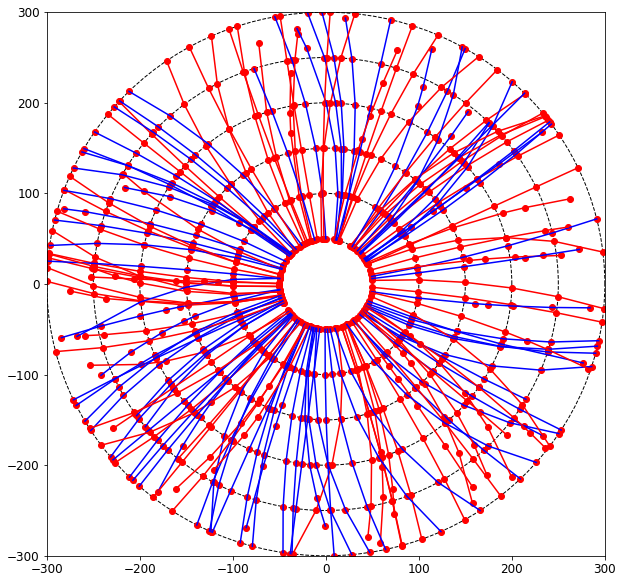

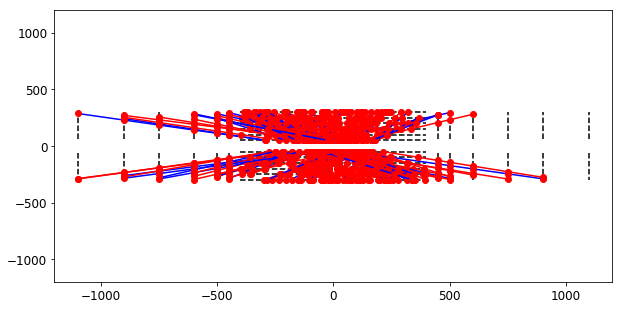

In [9]:

fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 300
ax.set_xlim((-1*zoom, zoom))
ax.set_ylim((-1*zoom, zoom))

detGeo.drawDetectorXY(ax)
plt.plot(recHits[:,1],recHits[:,2],'ro')

for s in solutions:
    color = "b" if (s[8] < 0) else "r"
    plt.plot(s[0],s[1],color)
    
fig, ax = plt.subplots(1, figsize=(10,5))
zoom = 1200
ax.set_xlim((-zoom, zoom))
ax.set_ylim((-1*zoom, zoom))

detGeo.drawDetectorZR(ax)

#plt.plot(recHits[:,3],np.sqrt(recHits[:,2]**2+recHits[:,1]**2),'ro')
for s in solutions:
    color = "b" if (s[8] < 0) else "r"
    hitPhi = np.arctan2(s[1],s[0])
    if hitPhi[0] < 0:    
        plt.plot(s[2],-1*s[3],color)
        plt.plot(s[2],-1*s[3],'ro')

    else:                
        plt.plot(s[2],+1*s[3],color)        
        plt.plot(s[2],+1*s[3],'ro')

# Test "Offline"  algorithm (ie: Hough transform) works

First try one track

### Implement the Hough transform

In [10]:
from TrackHelper import getPhiCircle
# given global posision and phi range, return consistent 1/rC
def getHT(hitR, hitPhi, phi):
    # Convert 0-2Pi
    if hitPhi<0: hitPhi += 2*np.pi

    phi_circle = getPhiCircle(phi,1)

    f = 2/hitR*(np.cos(hitPhi-phi_circle))
    return f

In [11]:
# given global posision and z0 range, return consistent theta
def getHT_ZR(hitZ, hitR, z):
    
        
    #f = np.arctan2((hitZ - z),hitR)
    #f[f<0] = f[f<0]+2*np.pi
    f = np.arctan2(hitR,(hitZ - z))
    return f

## Try on one track first

 Draw the track

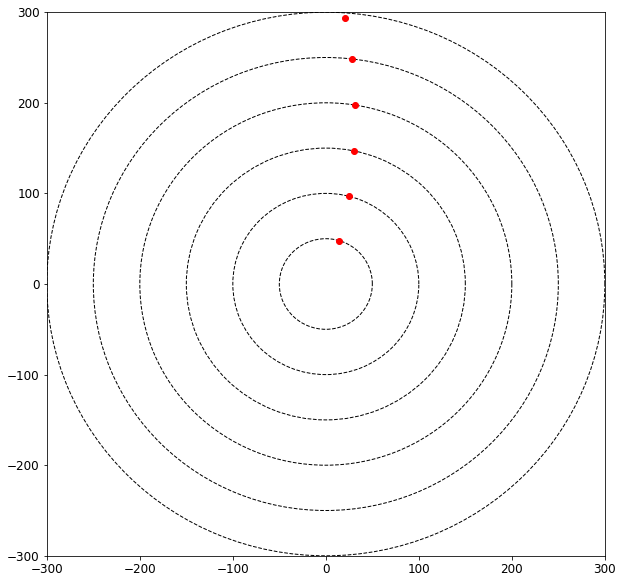

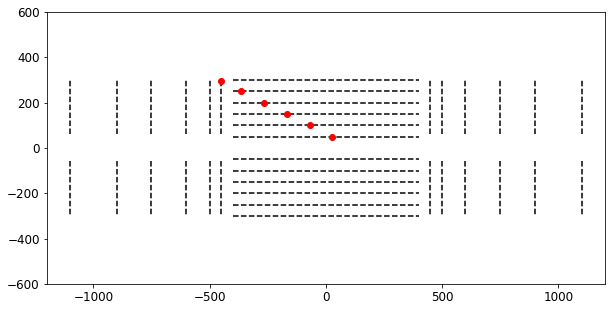

In [12]:
sTest = solutions[1+11]
testX = np.array(sTest[0])
testY = np.array(sTest[1])
testZ = np.array(sTest[2])
testR = np.array(sTest[3])

fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 300
ax.set_xlim((-1*zoom, zoom))
ax.set_ylim((-1*zoom, zoom))

detGeo.drawDetectorXY(ax)
plt.plot(testX,testY,'ro')

    
fig, ax = plt.subplots(1, figsize=(10,5))
zoom = 1200
ax.set_xlim((-zoom, zoom))
ax.set_ylim((-0.5*zoom, 0.5*zoom))

detGeo.drawDetectorZR(ax)
plt.plot(testZ,testR,'ro')

Truth Track, 1/Rc / phi / theta / z0 / q 0.0017977209366451447 1.2313966416109714 2.669666919378082 126.56227050693502 -1
236.86313042179404 -179.66684658724762
347.16399033665306 -485.89596368143026
457.4648502515121 -792.125080775613
567.765710166371 -1098.3541978697956
678.06657008123 -1404.5833149639784
775.7316669679344 -1675.731666967935


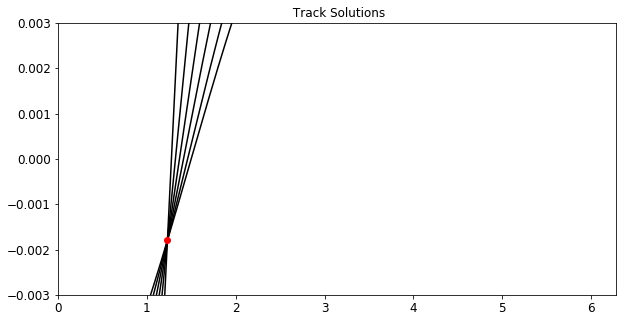

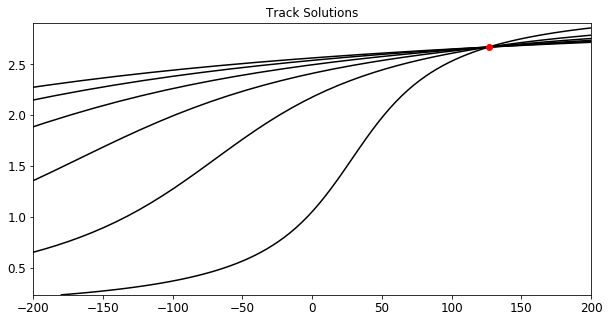

In [13]:
plt.figure(1, figsize=(10, 5))
plt.title(" Track Solutions")
plt.axis([0, 2*np.pi, -3*0.001,3*0.001])  

plt.figure(2, figsize=(10, 5))
plt.title("Track Solutions")
plt.axis([-200, 200, 30*np.pi/400,370*np.pi/400]) 

soln = solutions[1+11]

truePhi = soln[5]
trueQ   = soln[8]
trueRc  = soln[4]
trueTheta = soln[6]
trueZ0    = soln[7]
print("Truth Track, 1/Rc / phi / theta / z0 / q",1./trueRc,truePhi,trueTheta, trueZ0, trueQ)

m_max = np.tan(370*np.pi/400)
m_min = np.tan( 30*np.pi/400)

for hitItr in range(len(soln[0])):

    hitX = soln[0][hitItr]
    hitY = soln[1][hitItr]
    hitZ = soln[2][hitItr]
    hitR = soln[3][hitItr]

    hitPhi = np.arctan2(hitY, hitX)   

    # Convert 0-2Pi
    if hitPhi<0: hitPhi += 2*np.pi
    
    # Only consider plasiblel track (eg: from the orgin)
    phiXRange = np.linspace(hitPhi-np.pi/2, hitPhi+np.pi/2, 500)
    
    f = getHT(hitR, hitPhi,  phiXRange)

    plt.figure(1)
    plt.plot(phiXRange,f,"k")
    
    plt.figure(2)
    # Only consider plasiblel track (eg: from the orgin)

    #phiXRange = np.linspace(hitPhi-np.pi/2, hitPhi+np.pi/2, 500)
    z0Min = hitZ-(hitR/m_max)
    z0Max = hitZ-(hitR/m_min)    
    print(z0Min,z0Max)
    z0Range = np.linspace(z0Min, z0Max, 100)
    f = getHT_ZR(hitZ, hitR,  z0Range)
    plt.plot(z0Range,f,"k")

plt.figure(1)
plt.plot(truePhi,trueQ*1/trueRc,"ro")   

plt.figure(2)
plt.plot(trueZ0,trueTheta,"ro")    


plt.show()

# HT Algorithm


Basic idea here is to run the 2D HT algo twice.
First with theta/z0 with coarse binning to get the hits input in to the second HT
which will be Q/pt and phi

## First lets try to run the 2D HT algros seperately

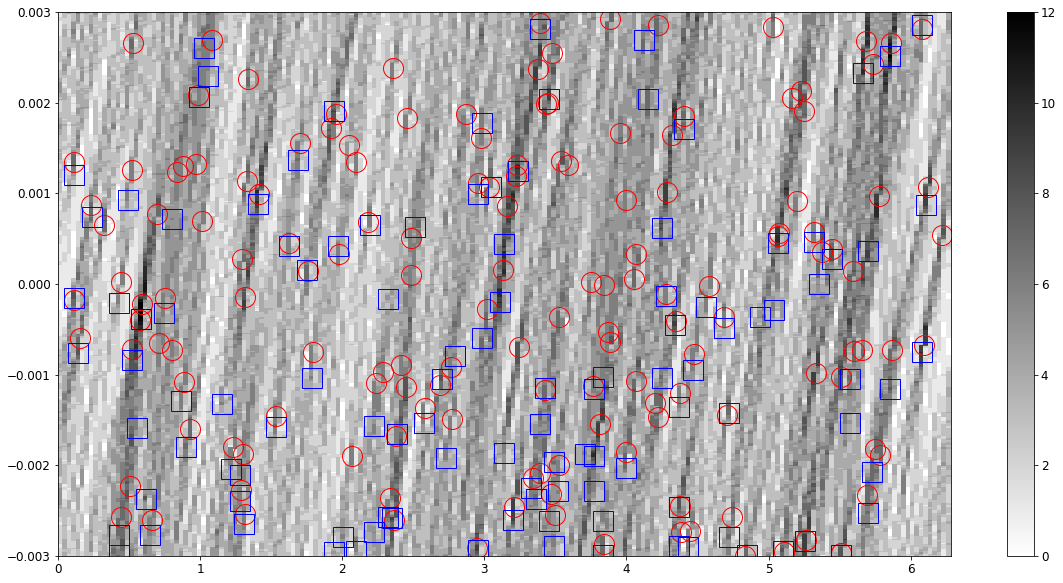

In [14]:
from HTTrackFinder import HTTrackFinding

def getHTForTrackFinding(hitR,hitPhi,phi):
    #Convert 0-2Pi
    if hitPhi<0: hitPhi += 2*np.pi
    phi_circle = phi - np.pi/2
    return 2/hitR*(np.cos(hitPhi-phi_circle))


HTFinderPtPhi = HTTrackFinding(0,2*np.pi,200,-3*0.001,3*0.001,400,getHTFunction=getHTForTrackFinding,
                               nLayers=(len(rDet)+2*len(zDet_disk))) 

fig, ax = plt.subplots(1, figsize=(20,10))

#
# Loop on rec hits
# 
for hitInfo in recHits:
    
    # hitInfo format (hitID,xHits[hitItr],yHits[hitItr],zHits[hitItr],hitItr)

    hitID  = hitInfo[0]
    hitX   = hitInfo[1]    
    hitY   = hitInfo[2]    
    #hitZ   = hitInfo[3]    
    hitLay = int(hitInfo[4])

    # convert to r and phi
    hitR = np.sqrt(hitX**2 + hitY**2)
    hitPhi = np.arctan2(hitY, hitX)
    if hitPhi<0: hitPhi += 2*np.pi
    
    HTFinderPtPhi.addHit(hitLay, hitID, hitR, hitPhi)


#    
# Plot Truth
#
for part in eventParticles:
    # part format (trkI,pt,phi,theta,z0,q,6)
    truePhi = part[2]
    trueQ   = part[5]
    trueRc  = part[1]    
    #eventParticles.append((trkI,pt,phi,q,6))

    ax.plot(truePhi,trueQ*1/trueRc,
            "o",markersize=20,markeredgewidth=1,markeredgecolor='r',markerfacecolor='None')

X, Y = np.meshgrid(HTFinderPtPhi.xBins, HTFinderPtPhi.yBins)
cmap = plt.get_cmap('binary')

HTFinderPtPhi.combineLayerMaps()

#
#  Tracks
#
plt.figure(1)

ax.set_xlim(0,2*np.pi)
ax.set_ylim(-3*0.001,3*0.001)
H = np.array(HTFinderPtPhi.HitDB.combinedHitsCounts).T
im = ax.pcolormesh(X, Y, H,cmap=cmap)
fig.colorbar(im, ax=ax)

recoTracks = HTFinderPtPhi.findTracks()
for rT in recoTracks:
    recPhi  = rT[0]
    recQ    = rT[2]
    recCurv = rT[1]

    ax.plot(recPhi,recCurv,
            "s",markersize=20,markeredgewidth=1,markeredgecolor='b',markerfacecolor='None')

        
plt.show()

In [15]:
solns = HTFinderPtPhi.getSolutions()

truthArr = np.array(eventTruth)
truthArr = np.delete(truthArr, 2, axis=1)
truthArr = np.delete(truthArr, 2, axis=1)
import pandas as pd
truthDict = {
    "hit_id" : pd.Series(truthArr[:,0]),
    "particle_id" : pd.Series(truthArr[:,1]),    
    "weight" : pd.Series(truthArr[:,3]),
}

truth = pd.DataFrame(truthDict)

In [16]:
import score
score.score_event(truth,solns)

0.2917594654788418

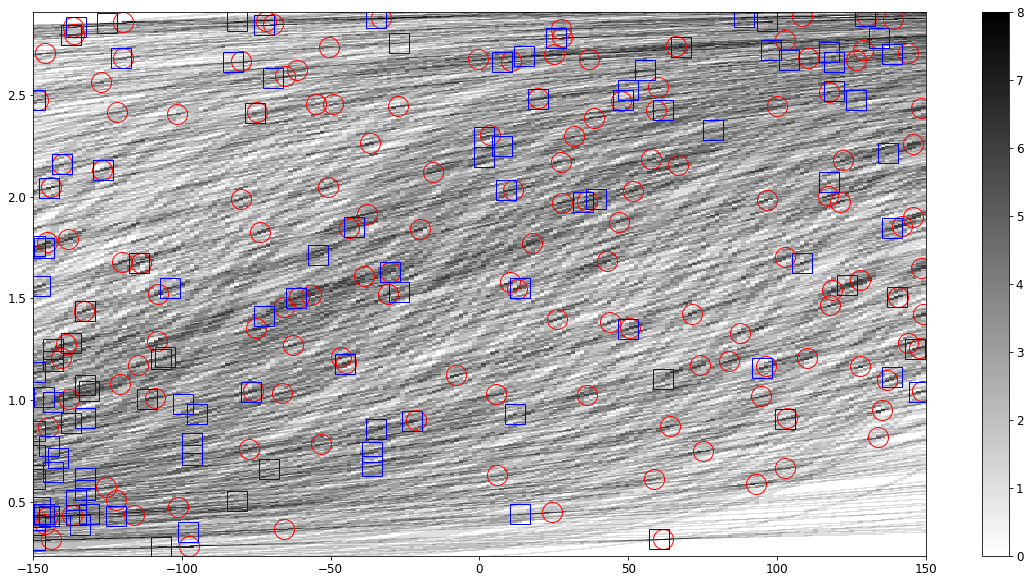

In [17]:
# given global posision and z0 range, return consistent theta
def getHT_ZRForTracking(hitZ, hitR, z):
    #f = np.arctan2((hitZ - z),hitR)
    #f[f<0] = f[f<0]+2*np.pi
    f = np.arctan2(hitR,(hitZ - z))
    return f

HTFinderZTheta = HTTrackFinding(-150,150,200,30*np.pi/400,370*np.pi/400,500,getHTFunction=getHT_ZRForTracking,
                                nLayers=(len(rDet)+2*len(zDet_disk))) 

fig, ax = plt.subplots(1, figsize=(20,10))

#
# Loop on rec hits
# 
for hitInfo in recHits:
    
    # hitInfo format (hitID,xHits[hitItr],yHits[hitItr],zHits[hitItr],hitItr)

    hitID  = hitInfo[0]
    hitX   = hitInfo[1]    
    hitY   = hitInfo[2]    
    hitZ   = hitInfo[3]    
    hitLay = int(hitInfo[4])
    
    # convert to r and phi
    hitR = np.sqrt(hitX**2 + hitY**2)
    
    HTFinderZTheta.addHit(hitLay, hitID, hitZ, hitR,doRangeCut=False)


#    
# Plot Truth
#
for part in eventParticles:
    # part format (trkI,pt,phi,theta,z0,q,6)
    truePhi = part[2]
    trueQ   = part[5]
    trueRc  = part[1]    
    trueZ0  = part[4]
    trueTheta  = part[3]

    ax.plot(trueZ0,trueTheta,
            "o",markersize=20,markeredgewidth=1,markeredgecolor='r',markerfacecolor='None')

X, Y = np.meshgrid(HTFinderZTheta.xBins, HTFinderZTheta.yBins)
cmap = plt.get_cmap('binary')

HTFinderZTheta.combineLayerMaps()

#
#  Tracks
#
plt.figure(1)

ax.set_xlim(-150,150)
ax.set_ylim(30*np.pi/400,370*np.pi/400)
H = np.array(HTFinderZTheta.HitDB.combinedHitsCounts).T
im = ax.pcolormesh(X, Y, H,cmap=cmap)
fig.colorbar(im, ax=ax)

recoTracks = HTFinderZTheta.findTracks()
for rT in recoTracks:
    recZ0  = rT[0]
    recQ    = rT[2]
    recTheta = rT[1]

    ax.plot(recZ0,recTheta,
            "s",markersize=20,markeredgewidth=1,markeredgecolor='b',markerfacecolor='None')

        
plt.show()

In [18]:
solnsZT = HTFinderZTheta.getSolutions()
score.score_event(truth,solnsZT)

0.1714922048997773

OK Lets set up a coarse gain track finding in Ztheta Then we can iterate over it and do a fine grain track finding in pt-phi

In [19]:
#HTFinderZThetaCoarse = HTTrackFinding(-150,150,7,np.pi/4,3*np.pi/4,10,getHTFunction=getHT_ZRForTracking) 
HTFinderZThetaCoarse = HTTrackFinding(-150,150,20,30*np.pi/400,370*np.pi/400,20,getHTFunction=getHT_ZRForTracking,
                                     nLayers=(len(rDet)+2*len(zDet_disk))) 


#
# Loop on rec hits
# 
for hitInfo in recHits:
    
    # hitInfo format (hitID,xHits[hitItr],yHits[hitItr],zHits[hitItr],hitItr)

    hitID  = hitInfo[0]
    hitX   = hitInfo[1]    
    hitY   = hitInfo[2]    
    hitZ   = hitInfo[3]    
    hitLay = int(hitInfo[4])
    
    # convert to r and phi
    hitR = np.sqrt(hitX**2 + hitY**2)
    
    HTFinderZThetaCoarse.addHit(hitLay, hitID, hitZ, hitR,doRangeCut=False)


#    
# Plot Truth
#
for part in eventParticles:
    # part format (trkI,pt,phi,theta,z0,q,6)
    truePhi = part[2]
    trueQ   = part[5]
    trueRc  = part[1]    
    trueZ0  = part[4]
    trueTheta  = part[3]

    ax.plot(trueZ0,trueTheta,
            "o",markersize=20,markeredgewidth=1,markeredgecolor='r',markerfacecolor='None')

X, Y = np.meshgrid(HTFinderZThetaCoarse.xBins, HTFinderZThetaCoarse.yBins)
cmap = plt.get_cmap('binary')

HTFinderZThetaCoarse.combineLayerMaps()



Test functions to get hits 

In [20]:
matchedHits = HTFinderZThetaCoarse.getHitsInBin(0,0,recHits)

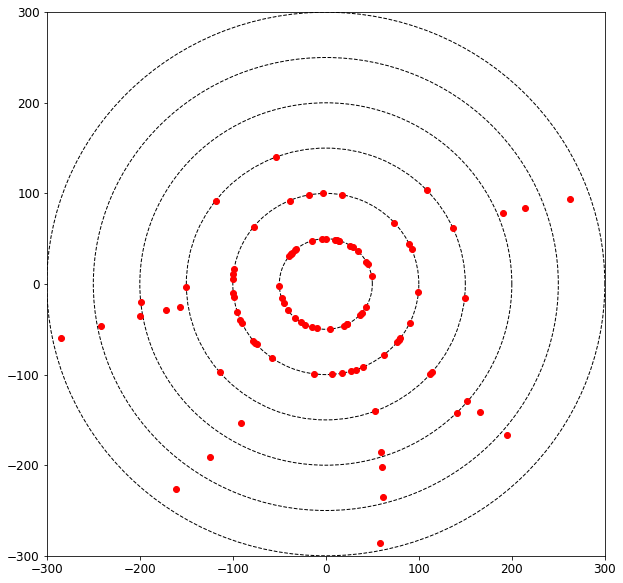

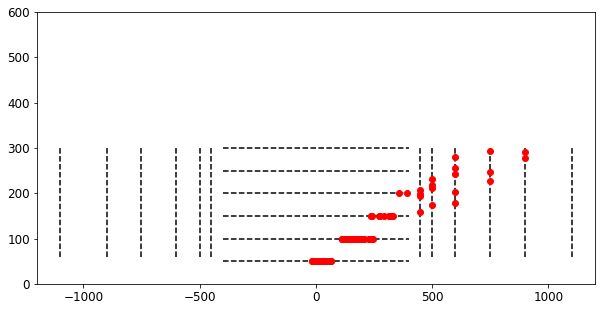

In [21]:
fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 300
ax.set_xlim((-1*zoom, zoom))
ax.set_ylim((-1*zoom, zoom))

detGeo.drawDetectorXY(ax)
plt.plot(matchedHits[:,1],matchedHits[:,2],'ro')

fig, ax = plt.subplots(1, figsize=(10,5))
zoom = 1200
ax.set_xlim((-zoom, zoom))
ax.set_ylim((0, zoom/2))

detGeo.drawDetectorZR(ax)

plt.plot(matchedHits[:,3],np.sqrt(matchedHits[:,2]**2+matchedHits[:,1]**2),'ro')

In [22]:
allRecoTracks = []
for iX in range(HTFinderZThetaCoarse.nXBins-1):
    for iY in range(HTFinderZThetaCoarse.nYBins-1):
        thisMatchedHits = HTFinderZThetaCoarse.getHitsInBin(iX,iY,recHits)
        
        if len(thisMatchedHits) < 5: continue
        
        HTFinderPtPhiFine = HTTrackFinding(0,2*np.pi,200,-3*0.001,3*0.001,400,getHTFunction=getHTForTrackFinding,
                                           nLayers=(len(rDet)+2*len(zDet_disk))) 

        
        #
        # Loop on rec hits
        # 
        for hitInfo in thisMatchedHits:
            hitID  = hitInfo[0]
            hitX   = hitInfo[1]    
            hitY   = hitInfo[2]    
            hitLay = int(hitInfo[4])
            
            # convert to r and phi
            hitR = np.sqrt(hitX**2 + hitY**2)
            hitPhi = np.arctan2(hitY, hitX)
            if hitPhi<0: hitPhi += 2*np.pi
            
            HTFinderPtPhiFine.addHit(hitLay, hitID, hitR, hitPhi)  
        
        HTFinderPtPhiFine.combineLayerMaps()
        recoTracks = HTFinderPtPhiFine.findTracks()
        allRecoTracks += recoTracks
        
        for rt in recoTracks:
            HTFinderZThetaCoarse.removeHitsFromTrack(rt,removeOverlap=False)

        print(iX,iY,len(recoTracks),len(thisMatchedHits))

0 0 4 97
0 1 6 132
0 2 2 104
0 3 0 83
0 4 3 89
0 5 3 77
0 6 2 66
0 7 1 54
0 8 1 42
0 9 1 37
0 10 2 43
0 11 0 31
0 12 1 35
0 13 2 30
0 14 0 33
0 15 1 37
0 16 2 41
0 17 1 34
0 18 6 42
1 0 0 66
1 1 0 82
1 2 0 88
1 3 1 85
1 4 0 65
1 5 1 68
1 6 0 62
1 7 0 55
1 8 1 41
1 9 2 41
1 10 0 26
1 11 0 29
1 12 0 32
1 13 1 27
1 14 0 33
1 15 1 34
1 16 0 32
1 17 1 29
1 18 0 8
2 0 1 64
2 1 0 82
2 2 0 79
2 3 0 79
2 4 1 63
2 5 0 51
2 6 1 59
2 7 2 64
2 8 0 40
2 9 0 32
2 10 0 25
2 11 1 27
2 12 0 24
2 13 0 20
2 14 0 28
2 15 1 34
2 16 0 37
2 17 1 24
2 18 0 11
3 0 0 44
3 1 0 76
3 2 0 76
3 3 2 81
3 4 1 63
3 5 0 52
3 6 1 44
3 7 0 51
3 8 0 51
3 9 0 43
3 10 0 32
3 11 0 29
3 12 0 28
3 13 0 27
3 14 0 28
3 15 0 30
3 16 3 42
3 17 0 19
3 18 0 13
4 0 0 45
4 1 0 69
4 2 2 72
4 3 1 62
4 4 0 49
4 5 2 53
4 6 0 40
4 7 1 44
4 8 1 44
4 9 0 42
4 10 2 42
4 11 0 28
4 12 0 29
4 13 0 26
4 14 1 24
4 15 0 31
4 16 1 28
4 17 1 20
4 18 1 17
5 0 0 43
5 1 1 55
5 2 0 57
5 3 0 62
5 4 0 52
5 5 0 41
5 6 0 37
5 7 0 41
5 8 2 48
5 9 0 32
5 10 0 36

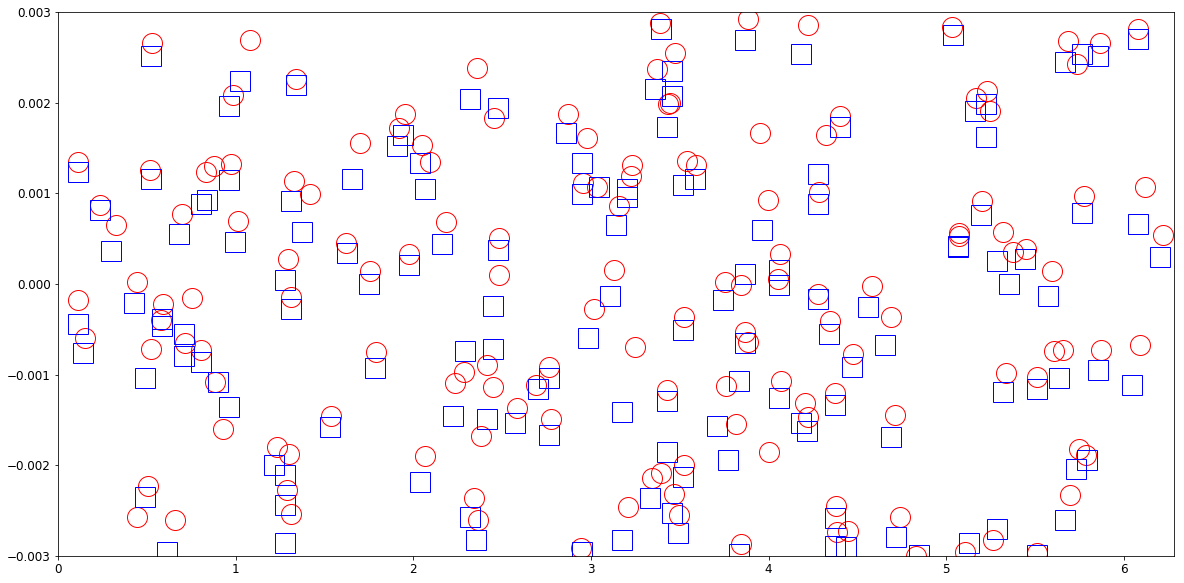

In [23]:
fig, ax = plt.subplots(1, figsize=(20,10))

#    
# Plot Truth
#
for part in eventParticles:
    # part format (trkI,pt,phi,theta,z0,q,6)
    truePhi = part[2]
    trueQ   = part[5]
    trueRc  = part[1]    
    #eventParticles.append((trkI,pt,phi,q,6))

    ax.plot(truePhi,trueQ*1/trueRc,
            "o",markersize=20,markeredgewidth=1,markeredgecolor='r',markerfacecolor='None')


#
#  Tracks
#
ax.set_xlim(0,2*np.pi)
ax.set_ylim(-3*0.001,3*0.001)
for rT in allRecoTracks:
    recPhi  = rT[0]
    recQ    = rT[2]
    recCurv = rT[1]

    ax.plot(recPhi,recCurv,
            "s",markersize=20,markeredgewidth=1,markeredgecolor='b',markerfacecolor='None')


        
plt.show()

In [24]:
solnsAll = HTFinderPtPhiFine.getSolutionsFromTracks(allRecoTracks)
score.score_event(truth,solnsAll)

0.7138084632516702